In [34]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# stats imports
from scipy.stats import norm, t
from scipy.stats import gaussian_kde

In [35]:
Time = 65 # days to simulate (not including non-trading days)
initial_value = 10000 # initial portfolio value

# portfolio + weights 
stocks = ['MSFT', 'TSLA', 'VTI', 'NVDA', 'AAPL', 'COST', 'PATH', 'SOFI', 'PFE', 'EBAY', 'ABNB']

custom_weights = { # make sure the order matches identically 
    'MSFT': 0.277,
    'TSLA': 0.154,
    'VTI': 0.146,
    'NVDA': 0.134, # 13.4% 
    'AAPL': 0.073, # 7.30%
    'COST': 0.061,
    'PATH': 0.053,
    'SOFI': 0.028,
    'PFE': 0.027,
    'EBAY': 0.025,  
    'ABNB': 0.022,   
}

weights = np.array([custom_weights[s] for s in stocks])
#print(weights.sum())  # check that weights ~= 1.0

In [36]:
import yfinance as yf

# importing data from yahoo finance
def getData(stocks, start, end):
    data = yf.download(stocks, start=start, end=end, auto_adjust=True,progress=False)['Close']  # downloading data
    returns = data.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    port_return = np.sum(meanReturns * weights) * Time
    port_std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return port_return, port_std

historic_days = 500 # adjust past days to use for data

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=historic_days) 
print("Current Date: " + str(endDate)) 

# importing S&P 500 for benchmark
spy_prices = yf.download('SPY', start=startDate, end=endDate, auto_adjust=True,progress=False)['Close'] 
spy_returns = spy_prices.pct_change().dropna()

# converting daily S&P 500 returns to a rolling average of returns (90 days)
spy_90d_returns = (1 + spy_returns).rolling(90).apply(np.prod, raw=True) - 1 
spy_90d_returns = spy_90d_returns.dropna()

Current Date: 2026-01-01 22:04:39.455105


In [37]:
# extracting daily returns
returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()
returns['portfolio'] = returns.dot(weights)

# display historical data
returns.tail(5)

Ticker,AAPL,ABNB,COST,EBAY,MSFT,NVDA,PATH,PFE,SOFI,TSLA,VTI,portfolio
Date,,,,,,,,,,,,
2025-12-24,0.005324,0.002125,0.019970,0.006544,0.002403,-0.003171,0.075188,0.006029,0.010666,-0.000330,0.003425,0.010085
2025-12-26,-0.001497,0.000293,0.001709,0.007210,-0.000635,0.010180,-0.018648,0.002397,-0.014920,-0.021034,-0.000618,-0.000443
2025-12-29,0.001317,-0.001462,-0.006309,0.029691,-0.001251,-0.012124,0.000594,-0.003587,-0.009235,-0.032724,-0.003768,0.001147
2025-12-30,-0.002484,0.002123,-0.002524,-0.007294,0.000780,-0.003613,-0.010683,-0.000400,-0.009694,-0.011335,-0.001596,-0.003028
2025-12-31,-0.004468,-0.008692,-0.003824,0.000000,-0.007918,-0.005545,-0.016797,-0.003601,-0.014307,-0.010365,-0.007637,-0.005855


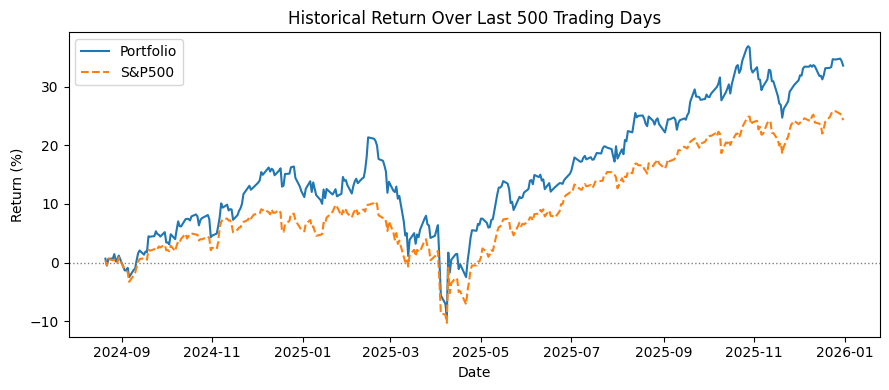

In [38]:
# historical returns plot

portfolio_returns = returns['portfolio'].iloc[-historic_days:]
spy_returns  = spy_returns.iloc[-historic_days:]

# cumulative return 
portfolio_gain = (1 + portfolio_returns).cumprod() - 1
spy_gain  = (1 + spy_returns).cumprod() - 1

plt.figure(figsize=(9, 4))
plt.plot(portfolio_gain.index, 100 * portfolio_gain, label='Portfolio')
plt.plot(spy_gain.index,  100 * spy_gain,  linestyle='--', label='S&P500')

plt.title(f'Historical Return Over Last {historic_days} Trading Days')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# historical value at risk
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)

# calculating expected return
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

print('Expected Portfolio Return    :      $', round(initial_value*pRet,2)) # you expect to make about $X
print('Value at Risk 95th CI (HVaR) :      $', round(initial_value*hVaR,2)) # there is about a 5% chance that you lose more than $X

Expected Portfolio Return    :      $ 610.72
Value at Risk 95th CI (HVaR) :      $ 1543.33


In [40]:
# parametric VaR
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

# parametric cVaR
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)
tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      $", round(initial_value*normVaR,2))
print("Normal CVaR 95th CI      :      $", round(initial_value*normCVaR,2))
print("t-dist VaR 95th CI       :      $", round(initial_value*tVaR,2))
print("t-dist CVaR 95th CI      :      $", round(initial_value*tCVaR,2))

Normal VaR 95th CI       :      $ 1202.68
Normal CVaR 95th CI      :      $ 1663.36
t-dist VaR 95th CI       :      $ 1138.46
t-dist CVaR 95th CI      :      $ 1766.39


In [41]:
sims = 15000 # number of simulations

# monte carlo simulation
meanM = np.full(shape=(Time, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(Time, sims), fill_value=0.0)

for m in range(0, sims):
    # MC loops
    Z = np.random.normal(size=(Time, len(weights)))
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_value

In [42]:
# overall percentage difference vs initial portfolio
final_values = portfolio_sims[-1, :]
final_returns = final_values / initial_value - 1

In [43]:
risk_free_rate = 0.04  
risk_free_adj = (1 + risk_free_rate)**(Time/365) - 1 # adjusted risk free rate for shorter/longer terms

print(f"Expected portfolio return         {final_returns.mean()*100:.3f}%")
print(f"STD of portfolio                  {final_returns.std()*100:.3f}%")
print(f"Sharpe Ratio of portfolio         {((final_returns.mean() - risk_free_adj) / final_returns.std()):.3f}")


Expected portfolio return         6.365%
STD of portfolio                  11.721%
Sharpe Ratio of portfolio         0.483


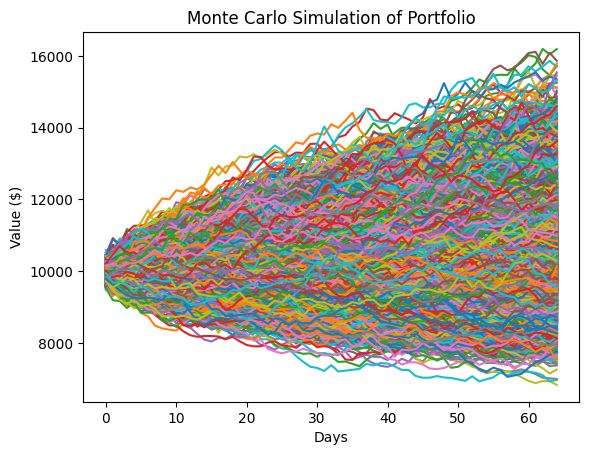

In [44]:
# monte carlo visualization
plt.plot(portfolio_sims)
plt.ylabel('Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of Portfolio')
plt.show()

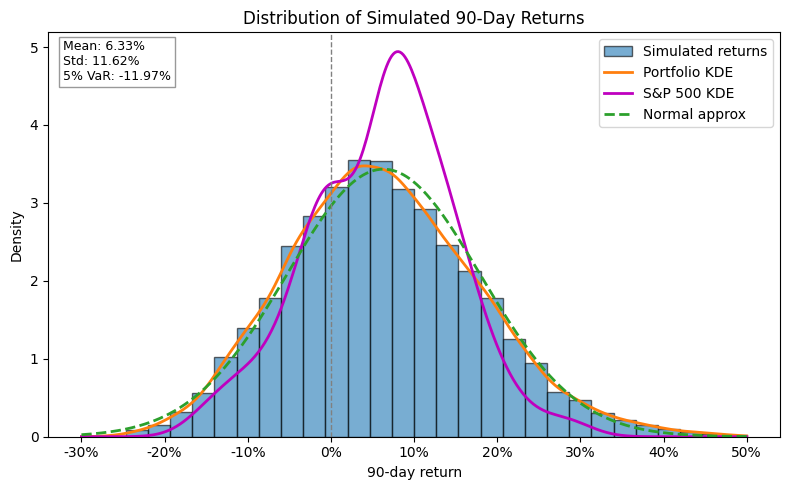

In [45]:
# portfolio dashboard

plot_min, plot_max = -0.30, 0.50  # -30% to +60%

# simulated portfolio returns
mask = (final_returns >= plot_min) & (final_returns <= plot_max)
ret = final_returns[mask]

# s&p500 historical returns
spy_mask = (spy_90d_returns >= plot_min) & (spy_90d_returns <= plot_max)
spy_ret = spy_90d_returns[spy_mask]
spy_ret = np.asarray(spy_ret).ravel()  
#--------------
mean_ret = ret.mean()
std_ret  = ret.std()
var_5    = np.percentile(ret, 5)   # 5th percentile (95% VaR threshold)

# Convert to percentage strings
mean_str = f"Mean: {100*mean_ret:.2f}%"
std_str  = f"Std: {100*std_ret:.2f}%"
var_str  = f"5% VaR: {100*var_5:.2f}%"   # threshold return at 5th percentile
#--------------
#print("Number of s&p 500 samples:", len(spy_ret))  

xs = np.linspace(plot_min, plot_max, 400)

# density curve for portfolio and s&p 500
kde_port = gaussian_kde(ret)
density_port = kde_port(xs)

kde_spy = gaussian_kde(spy_ret)
density_spy = kde_spy(xs)


# normal curve from simulated portfolio mean/std
mu = ret.mean()
sigma = ret.std()
normal_pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu) / sigma)**2)


# plt histogram + density curves
plt.figure(figsize=(8, 5))

# histogram of simulated portfolios
plt.hist(
    ret,
    bins=30,
    range=(plot_min, plot_max),
    density=True,
    alpha=0.6,
    edgecolor='black',
    label='Simulated returns'
)

# plot portfolio curve, s&p curve, and normal distribution
plt.plot(xs, density_port, linewidth=2, label='Portfolio KDE')
plt.plot(xs, density_spy, 'm-', linewidth=2, label='S&P 500 KDE')
plt.plot(xs, normal_pdf, linestyle='--', linewidth=2, label='Normal approx')

# 0% return reference line
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# plot labels
plt.xlabel('90-day return')
plt.ylabel('Density')
plt.title('Distribution of Simulated 90-Day Returns')
plt.xticks(
    [-0.30, -0.20, -0.10, 0, 0.10, 0.20, 0.30, 0.40, 0.50],
    ['-30%', '-20%', '-10%', '0%', '10%', '20%', '30%', '40%', '50%']
)
plt.legend()
# ------------
ax = plt.gca()
textstr = "\n".join([mean_str, std_str, var_str])

ax.text(
    0.02, 0.98, textstr,
    transform=ax.transAxes,
    fontsize=9,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='gray')
)
# -----------
plt.tight_layout()
plt.show()


In [46]:
def pct(mask):
    return 100 * np.mean(mask)

# creating dataframe of return probabilities by range
rows = [
    {"Range": "<= -30%",      "Probability": pct(final_returns < -0.30)},
    {"Range": "-30% to -20%", "Probability": pct((final_returns >= -0.30) & (final_returns < -0.20))},
    {"Range": "-20% to -10%", "Probability": pct((final_returns >= -0.20) & (final_returns < -0.10))},
    {"Range": "-10% to 0%",   "Probability": pct((final_returns >= -0.10) & (final_returns < 0))},
    {"Range": "0% to 10%",    "Probability": pct((final_returns >= 0) & (final_returns < 0.10))},
    {"Range": "10% to 20%",   "Probability": pct((final_returns >= 0.10) & (final_returns < 0.20))},
    {"Range": "20% to 30%",   "Probability": pct((final_returns >= 0.20) & (final_returns < 0.30))},
    {"Range": ">= 30%",       "Probability": pct(final_returns >= 0.30)},
]

probability_range = pd.DataFrame(rows)

# printing ranges
print("Return Probabilities by Range:")
print(probability_range.to_string(index=False, formatters={"Probability": "{:.2f}%".format}))

Return Probabilities by Range:
       Range Probability
     <= -30%       0.02%
-30% to -20%       0.51%
-20% to -10%       6.93%
  -10% to 0%      22.85%
   0% to 10%      33.82%
  10% to 20%      23.72%
  20% to 30%       9.21%
      >= 30%       2.94%


In [47]:
print(f"What’s the chance I’m down more than 20% in the next 3 months?          : {pct((final_returns < -0.20)):6.2f}%")
print(f"What’s the chance that I'm down at all?                                 : {pct((final_returns < -0.00)):6.2f}%")
print(f"How often do I get >20% in 90 days?”                                    : {pct((final_returns > 0.20)):6.2f}%")

What’s the chance I’m down more than 20% in the next 3 months?          :   0.53%
What’s the chance that I'm down at all?                                 :  30.31%
How often do I get >20% in 90 days?”                                    :  12.15%


In [48]:
# defining Monte Carlo VaR
def mcVaR(returns, alpha=5):
    """Input: Series of simulated final portfolio values
       Output: alpha-percentile of that distribution
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

# defining Monte Carlo CVaR
def mcCVaR(returns, alpha=5):
    """ Input: Series of simulated final portfolio values
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
    
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initial_value - mcVaR(portResults, alpha=5)
CVaR = initial_value - mcCVaR(portResults, alpha=5)

print('VaR: Based on these simulations, there’s about a 5% chance I lose more than ${}'.format(round(VaR,2))) # Monte Carlo VaR
print('CVaR: If I end up in that worst 5%, my average loss is about ${}'.format(round(CVaR,2)))                # Monte Carlo CVaR

VaR: Based on these simulations, there’s about a 5% chance I lose more than $1197.42
CVaR: If I end up in that worst 5%, my average loss is about $1564.84
